In [1]:
import os # Configure which GPU 
#import sys
import torch
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) 

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

no_preview = True

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

/Users/jokuo/Desktop/ECE257B Final Project/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Num GPUs Available:  0


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement
from sionna.mimo.precoding import normalize_precoding_power, grid_of_beams_dft
from sionna.rt import visualize 
import math

In [3]:
# --- Find cell index in the coverage grid for each user position ---
def find_cell_index(user_pos, cell_centers, cell_size):
    num_users = user_pos.shape[0]
    cell_zero_pos_x = cell_centers[0,0,0]
    cell_zero_pos_y = cell_centers[0,0,1]
    del_x = cell_size[0]
    del_y = cell_size[1]

    cell_index_x = []
    cell_index_y = []
    distance = []
    
    for user in range(num_users):
        user_pos_x = user_pos[user, 0]
        user_pos_y = user_pos[user, 1]
        
        # Compute index based on cell size and reference position
        x_index = tf.math.floor(((user_pos_x - cell_zero_pos_x) - del_x/2) / del_x + 1)
        y_index = tf.math.floor(((user_pos_y - cell_zero_pos_y) - del_y/2) / del_y + 1)
        
        cell_index_x.append(int(x_index))
        cell_index_y.append(int(y_index))

        # Distance between user and center of the cell
        cell_x = cell_centers[int(y_index), int(x_index), 0]
        cell_y = cell_centers[int(y_index), int(x_index), 1]
        dd = tf.math.sqrt((cell_x - user_pos_x)**2 + (cell_y - user_pos_y)**2)
        distance.append(dd)
    
    return cell_index_x, cell_index_y, distance

# --- Compute boolean coverage map from path gain ---
def calculate_cover(coveragemap_list, txpow, threshold, limitarea=True, ar_begin=40, ar_end=200, col_begin=50, col_end=250):
    map = np.zeros_like(coveragemap_list[0], dtype=bool)
    mapp = 10. * np.log10(coveragemap_list[0])
    mapp = (mapp + txpow > threshold)
    map = np.logical_or(map, mapp)
    if limitarea:
        map = map[ar_begin:ar_end, col_begin:col_end]
    return map

# --- Configure scene with specific array and transmitter parameters ---
def config_scene(scene, num_rows, num_cols, pattern, bs_pwr, tx_pos, look_at=[0,0,0]):
    scene.tx_array = PlanarArray(num_rows=num_rows,
                                 num_cols=num_cols,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern=pattern,
                                 polarization="V")

    scene.rx_array = PlanarArray(num_rows=1,
                                 num_cols=1,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern="iso",
                                 polarization="V")

    scene.remove('tx')  # Remove existing TX (if any)
    scene.add(Transmitter(name='tx',
                          position=tx_pos,
                          look_at=look_at,
                          power_dbm=bs_pwr))
    return scene

# --- Compute coverage map from scene object ---
def compute_cm(scene):
    cm = scene.coverage_map(
        max_depth=5,
        diffraction=True,
        cm_cell_size=(5., 5.),
        combining_vec=None,
        precoding_vec=None,
        num_samples=int(10e6)
    )
    return cm

# --- Convert physical coordinates to grid index ---
def return_geoidx(pslist):
    x0 = -805.583664
    y0 = -688.600626
    del_x = 5
    del_y = 5
    x, y = pslist[:2]
    x_idx = np.round((x - x0) / del_x)
    y_idx = np.round((y - y0) / del_y)
    return int(x_idx), int(y_idx)

# --- Compare two coverage maps and count lit-up blocks ---
def calculate_sinr_performance(coveragemap, uebaseline_map, txpow, threshold):
    cm_map = 10. * np.log10(coveragemap[0])
    ue_map = 10. * np.log10(uebaseline_map[0])
    
    cm_map = (cm_map > threshold)
    ue_map = (ue_map > threshold)

    # Logical union of lit-up blocks
    mapp = np.logical_or(cm_map, ue_map)

    num_lightup_blocks = np.sum(mapp)
    num_baseline_blocks = np.sum(ue_map)
    return num_lightup_blocks, num_baseline_blocks

# --- Basic SINR map creation and block counting ---
def calculate_sinr(coveragemap_list, txpow, threshold):
    map = np.zeros_like(coveragemap_list[0], dtype=bool)
    mapp = 10. * np.log10(coveragemap_list[0])
    mapp = (mapp > threshold)
    map = np.logical_or(map, mapp)
    num_lightup_blocks = np.sum(map)
    return map, num_lightup_blocks

# --- Variant without TX power offset (already in dB) ---
def calculate_sinr_testing(coveragemap_list, threshold):
    mapp = 10. * np.log10(coveragemap_list[0])
    mapp = (mapp > threshold)
    num_lightup_blocks = np.sum(mapp)
    return mapp, num_lightup_blocks

# --- Compute average SNR (linear scale) from a list of user positions ---
def calculate_db_snr_all(user_pos, cell_centers, cell_size, coveragemap_tensor):
    index_x, index_y, distance = find_cell_index(user_pos, cell_centers, cell_size)
    num_users = len(index_x)
    num_iteration = 0
    snrs = 0

    for user in range(num_users):
        val = coveragemap_tensor[0, index_y[user], index_x[user]].numpy()
        if val == 0:
            continue
        snrs += val
        num_iteration += 1

    return snrs / num_iteration if num_iteration > 0 else 0


In [4]:
# --- Function to divide total transmit power among antennas ---
def divide_power_dBm(P_dBm, N_list):
    """
    Divide a total power (in dBm) evenly across N antennas.
    Returns a dictionary with N as key and resulting per-antenna power in dBm as value.
    """
    P_linear = 10**(P_dBm / 10)  # Convert dBm to linear (mW)
    power_dict = {N: 10 * np.log10(P_linear / N) for N in N_list}  # Convert back to dBm per antenna
    return power_dict

# --- Power division example ---
P = 10  # Total TX power in dBm
N_values = [1, 2, 4, 8, 16]  # Antenna counts
Pw_maps = divide_power_dBm(P, N_values)  # Per-antenna power for each config
print(Pw_maps)  # Check results

{1: 10.0, 2: 6.989700043360188, 4: 3.979400086720376, 8: 0.9691001300805642, 16: -2.041199826559248}


In [5]:
# --- Load scene and define physical parameters ---
sn = load_scene(sionna.rt.scene.munich)

# Set portion of the scene to focus on
x_factor = 0.7  # Use 70% of total width
y_factor = 0.7  # Use 70% of total height

# Compute the cropped scene size
scene_x_length = sn.size[0].numpy() * x_factor
scene_y_length = sn.size[1].numpy() * y_factor

# Get center position of the scene
scene_center_x = sn.center[0].numpy()
scene_center_y = sn.center[1].numpy()

# Compute starting point for scanning (lower-left of grid)
start_x = scene_center_x - (scene_x_length / 2)
start_y = scene_center_y - (scene_y_length / 2)

# Create a Y-position grid with 30m spacing (you could also create X if needed)
y_grid = np.arange(start_y, start_y + scene_y_length + 30, 30)
print("Y-grid:", y_grid)


Y-grid: [-507.75528564 -477.75528564 -447.75528564 -417.75528564 -387.75528564
 -357.75528564 -327.75528564 -297.75528564 -267.75528564 -237.75528564
 -207.75528564 -177.75528564 -147.75528564 -117.75528564  -87.75528564
  -57.75528564  -27.75528564    2.24471436   32.24471436   62.24471436
   92.24471436  122.24471436  152.24471436  182.24471436  212.24471436
  242.24471436  272.24471436  302.24471436  332.24471436  362.24471436]


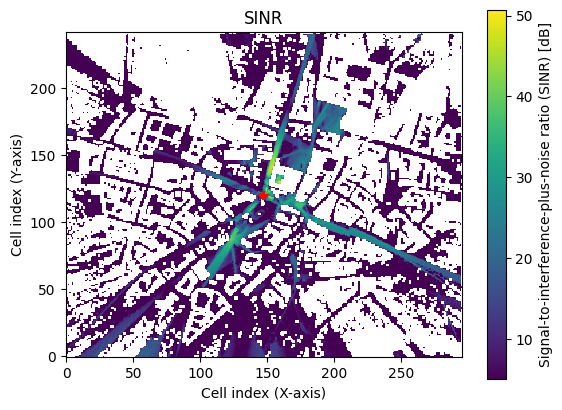

In [6]:
# --- Configure and simulate 1 TX, 64 antenna array (8x8) ---
tx_height = 50  # TX elevation in meters

# Use per-antenna power for N=1 (which is just full power, no division)
scene_1tx_64ant = config_scene(sn, 8, 8, 'dipole', Pw_maps[1], [scene_center_x, scene_center_y, tx_height])

# Compute coverage map for the configured scene
cm_1tx_64ant = compute_cm(scene_1tx_64ant)

# --- Visualize SINR ---
im1 = cm_1tx_64ant.show(metric="sinr", vmin=5)  # Set vmin to filter low SINR


In [7]:
# --- Function to generate transmitter positions in a grid over the scene ---
def generate_tx_positions(myscene, tx_height=49.285, x_points=100, y_points=100, x_factor=0.7, y_factor=0.7):
    """
    Generates a 2D grid of TX positions in the center region of the scene.
    
    Parameters:
        myscene      : The loaded Sionna scene.
        tx_height    : Height (Z) of all transmitters.
        x_points     : Number of TX grid points along X-axis.
        y_points     : Number of TX grid points along Y-axis.
        x_factor     : Fraction of total scene width to use (to avoid edges).
        y_factor     : Fraction of total scene height to use.

    Returns:
        tx_positions : N x 3 array of transmitter 3D positions.
        x_array      : 1D array of X positions used in grid.
        y_array      : 1D array of Y positions used in grid.
    """

    # Compute usable scene dimensions (crop based on x/y factors)
    scene_x_length = myscene.size[0].numpy() * x_factor
    scene_y_length = myscene.size[1].numpy() * y_factor

    # Get center of the scene
    scene_center_x = myscene.center[0].numpy()
    scene_center_y = myscene.center[1].numpy()

    # Calculate lower-left start corner of the usable area
    start_x = scene_center_x - scene_x_length / 2
    start_y = scene_center_y - scene_y_length / 2

    # Create evenly spaced grid of X and Y coordinates
    x_array = np.linspace(start_x, start_x + scene_x_length, x_points)
    y_array = np.linspace(start_y, start_y + scene_y_length, y_points)

    # Generate TX position array by pairing each (x, y) with fixed height
    tx_positions = np.empty((0, 3), dtype=np.float32)
    for i in range(len(x_array)):
        for j in range(len(y_array)):
            array_temp = np.array([x_array[i], y_array[j], tx_height])
            tx_positions = np.vstack((tx_positions, array_temp))
    
    return tx_positions, x_array, y_array

# setting the TX height for splitting up the antennas
TX_height = 20

tx_positions, x_array, y_array = generate_tx_positions(sn, tx_height = TX_height, 
                                                       x_points = 1, y_points = 2, x_factor = 0, y_factor = 0.1)
# Print generated TX positions
print(tx_positions)

[[ -67.85046387 -146.06456299   20.        ]
 [ -67.85046387  -25.50098877   20.        ]]


In [8]:
# --- Load a fresh instance of the Munich scene for 2-TX setup ---
scene2 = load_scene(sionna.rt.scene.munich)

# Basic scene settings
scene2.bandwidth = 100e6
scene2.frequency = 2.14e9
scene2.synthetic_array = True

# For plotting later or storing results
x = []
y = []
sinr_TH = 5  # SINR threshold in dB

# To store SINR coverage maps for each transmitter
coverage_TX1 = {}
coverage_TX2 = {}

# --- Generate look-at target positions (used by both TXs) ---
look_at_pos, _, _ = generate_tx_positions(
    sn, 
    tx_height=TX_height, 
    x_points=5, 
    y_points=5, 
    x_factor=0.7, 
    y_factor=0.7
)

# Store look-at positions in a dict (optional, for later reference or plotting)
look_at_dict = {i: look_at for i, look_at in enumerate(look_at_pos)}
print("Generated Look-At Points:")
print(look_at_dict)

# --- Loop over each TX position (assumes tx_positions is already defined) ---
for i, pos in enumerate(tx_positions):
    print(f"TX{i+1} Position: {pos}")
    
    # Sweep through all look-at directions for this TX
    for j, look_at in enumerate(look_at_pos):
        print(f"  Look-at {j}: {look_at}")

        # Configure scene for this TX position and look-at
        scene2 = config_scene(scene2, 4, 8, 'dipole', Pw_maps[2], pos, look_at)

        # Compute SINR coverage map
        cm2 = compute_cm(scene2)

        # Calculate SINR coverage based on threshold
        sinr_cover, number_lightup_blk = calculate_sinr_testing(cm2.sinr, sinr_TH)
        print(f"    Lit-up blocks: {number_lightup_blk}")

        # Save coverage map in the appropriate TX dict
        if i == 0:
            coverage_TX1[j] = sinr_cover
        else:
            coverage_TX2[j] = sinr_cover


Generated Look-At Points:
{0: array([-584.2637146 , -507.75528564,   20.        ]), 1: array([-584.2637146 , -296.76903076,   20.        ]), 2: array([-584.2637146 ,  -85.78277588,   20.        ]), 3: array([-584.2637146,  125.203479 ,   20.       ]), 4: array([-584.2637146 ,  336.18973389,   20.        ]), 5: array([-326.05708923, -507.75528564,   20.        ]), 6: array([-326.05708923, -296.76903076,   20.        ]), 7: array([-326.05708923,  -85.78277588,   20.        ]), 8: array([-326.05708923,  125.203479  ,   20.        ]), 9: array([-326.05708923,  336.18973389,   20.        ]), 10: array([ -67.85046387, -507.75528564,   20.        ]), 11: array([ -67.85046387, -296.76903076,   20.        ]), 12: array([-67.85046387, -85.78277588,  20.        ]), 13: array([-67.85046387, 125.203479  ,  20.        ]), 14: array([-67.85046387, 336.18973389,  20.        ]), 15: array([ 190.3561615 , -507.75528564,   20.        ]), 16: array([ 190.3561615 , -296.76903076,   20.        ]), 17: array

/var/folders/_w/r7_cn0md5pd8k_yb0ns3xzlm0000gn/T/ipykernel_22479/3875331987.py:114: RuntimeWarning: divide by zero encountered in log10
  mapp = 10. * np.log10(coveragemap_list[0])


    Lit-up blocks: 959
  Look-at 1: [-584.2637146  -296.76903076   20.        ]
    Lit-up blocks: 755
  Look-at 2: [-584.2637146   -85.78277588   20.        ]
    Lit-up blocks: 336
  Look-at 3: [-584.2637146  125.203479    20.       ]
    Lit-up blocks: 425
  Look-at 4: [-584.2637146   336.18973389   20.        ]
    Lit-up blocks: 684
  Look-at 5: [-326.05708923 -507.75528564   20.        ]
    Lit-up blocks: 825
  Look-at 6: [-326.05708923 -296.76903076   20.        ]
    Lit-up blocks: 877
  Look-at 7: [-326.05708923  -85.78277588   20.        ]
    Lit-up blocks: 349
  Look-at 8: [-326.05708923  125.203479     20.        ]
    Lit-up blocks: 611
  Look-at 9: [-326.05708923  336.18973389   20.        ]
    Lit-up blocks: 409
  Look-at 10: [ -67.85046387 -507.75528564   20.        ]
    Lit-up blocks: 515
  Look-at 11: [ -67.85046387 -296.76903076   20.        ]
    Lit-up blocks: 519
  Look-at 12: [-67.85046387 -85.78277588  20.        ]
    Lit-up blocks: 522
  Look-at 13: [-67.8

Best look-at locations found:
  TX1 → [448.56278687 336.18973389  20.        ]
  TX2 → [-326.05708923 -507.75528564   20.        ]
  Overlap blocks: 1115


/var/folders/_w/r7_cn0md5pd8k_yb0ns3xzlm0000gn/T/ipykernel_22479/3875331987.py:114: RuntimeWarning: divide by zero encountered in log10
  mapp = 10. * np.log10(coveragemap_list[0])


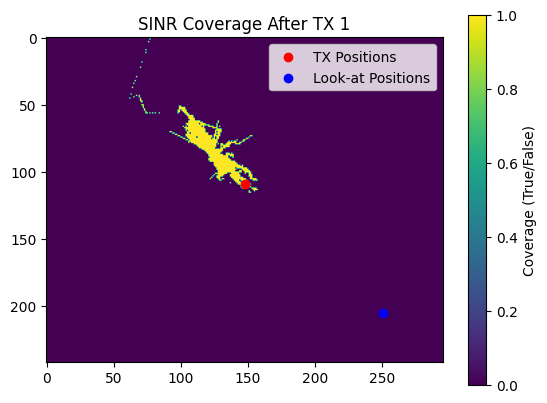

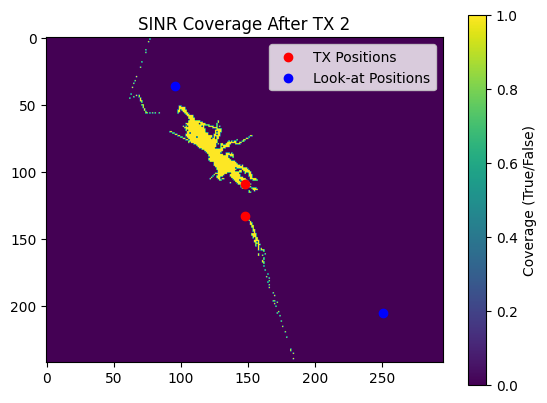

In [9]:
# --- Utility: Convert 2D world coordinates to grid indices ---
def return_geoidx2(pslist):
    x0 = -805.583664
    y0 = -688.600626
    del_x = 5
    del_y = 5
    x, y = pslist[:2]
    x_idx = np.round((x - x0) / del_x)
    y_idx = np.round((y - y0) / del_y)
    return int(x_idx), int(y_idx)

# --- Compare two SINR coverage maps using logical OR ---
def compare_sinr_performance(cm_map1, cm_map2):
    overlap_map = np.logical_or(cm_map1, cm_map2)
    num_overlap_blocks = np.sum(overlap_map)
    return overlap_map, num_overlap_blocks

# --- Find best pair of look-at positions from coverage_TX1 and coverage_TX2 ---
max_overlap = float('-inf')
best_location = (None, None)
optimal_map = 0

for key1, val1 in coverage_TX1.items():
    for key2, val2 in coverage_TX2.items():
        overlap_map, num_overlap_blocks_temp = compare_sinr_performance(val1, val2)
        if num_overlap_blocks_temp > max_overlap:
            max_overlap = num_overlap_blocks_temp
            optimal_map = overlap_map
            best_location = (look_at_dict[key1], look_at_dict[key2])

print("Best look-at locations found:")
print("  TX1 →", best_location[0])
print("  TX2 →", best_location[1])
print("  Overlap blocks:", max_overlap)

# --- Reload fresh scene for actual optimal SINR visualization ---
sn2 = load_scene(sionna.rt.scene.munich)

# Scene setup
sn2.bandwidth = 100e6
sn2.frequency = 2.14e9
sn2.synthetic_array = False  # True = idealized, False = realistic (maybe your intention)

# SINR threshold for visualization
sinr_TH = 5

# Tracking lists
x_theory = []     # TX grid positions
y_theory = []
x = []            # Look-at grid positions
y = []
sinr_cover = 0    # Final accumulated coverage map

# --- Loop through all TXs and apply the best look-at direction found earlier ---
for i, tx_pos in enumerate(tx_positions):
    plt.figure()
    
    # Get TX position in grid
    x_temp, y_temp = return_geoidx2(tx_pos)
    x_theory.append(x_temp)
    y_theory.append(y_temp)

    # Get best look-at direction for current TX
    x_look, y_look = return_geoidx2(best_location[i])
    x.append(x_look)
    y.append(y_look)

    # Configure scene and compute SINR map
    sn_2tx = config_scene(sn2, 4, 8, 'dipole', Pw_maps[2], tx_pos, best_location[i])
    cm_2tx = compute_cm(sn_2tx)

    # Calculate SINR coverage above threshold
    sinr_cover_temp, number_lightup_blk = calculate_sinr_testing(cm_2tx.sinr, sinr_TH)

    # Combine SINR coverages across TXs
    sinr_cover, _ = compare_sinr_performance(sinr_cover, sinr_cover_temp)

    # --- Plotting the coverage map ---
    plt.scatter(x_theory, y_theory, label='TX Positions', color='red')
    plt.scatter(x, y, label='Look-at Positions', color='blue')
    plt.imshow(sinr_cover, cmap='viridis')
    plt.title(f"SINR Coverage After TX {i+1}")
    plt.colorbar(label='Coverage (True/False)')
    plt.legend()
    plt.show()


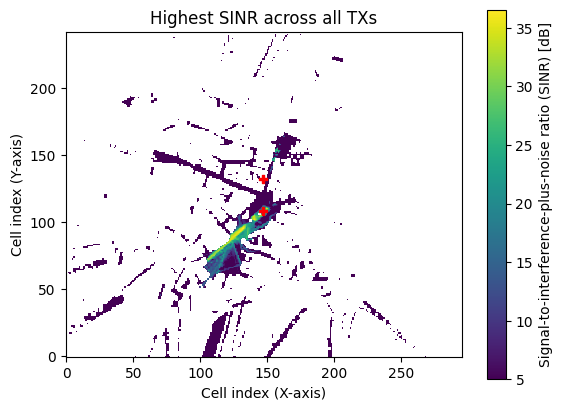

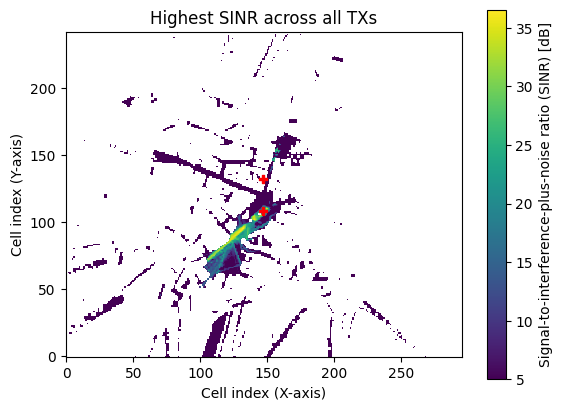

In [10]:
# --- Configure scene for MISO (multiple TXs in one scene) ---
def config_scene_MISO(scene, num_rows, num_cols, pattern, bs_pwr, tx_pos, iter_num, look_at=[0, 0, 0]):
    """
    Adds a transmitter to the scene for MISO setup.

    Parameters:
        scene     : The scene object to add TXs to.
        num_rows  : Number of rows in TX antenna array.
        num_cols  : Number of cols in TX antenna array.
        pattern   : Antenna radiation pattern (e.g., 'dipole').
        bs_pwr    : TX power in dBm (per antenna).
        tx_pos    : Transmitter position [x, y, z].
        iter_num  : Index of the transmitter (used to name it uniquely).
        look_at   : Direction the TX is facing.

    Returns:
        scene     : Updated scene with the new transmitter.
    """
    # Basic scene settings (optional if already set outside)
    scene.bandwidth = 100e6
    scene.frequency = 2.14e9
    scene.synthetic_array = True

    # TX array configuration
    scene.tx_array = PlanarArray(
        num_rows=num_rows,
        num_cols=num_cols,
        vertical_spacing=0.5,
        horizontal_spacing=0.5,
        pattern=pattern,
        polarization="V"
    )

    # RX configuration (assumes 1x1 isotropic receiver)
    scene.rx_array = PlanarArray(
        num_rows=1,
        num_cols=1,
        vertical_spacing=0.5,
        horizontal_spacing=0.5,
        pattern="iso",
        polarization="V"
    )

    # Add transmitter with unique name (e.g., tx0, tx1)
    scene.add(Transmitter(
        name=f'tx{iter_num}',
        position=tx_pos,
        look_at=look_at,
        power_dbm=bs_pwr
    ))

    return scene

# --- Load a clean scene and prepare MISO setup ---
scene2 = load_scene(sionna.rt.scene.munich)

# SINR threshold for reference
sinr_TH = 5

# --- Add all TXs into the scene for a full MISO simulation ---
for i, tx_pos in enumerate(tx_positions):
    scene2 = config_scene_MISO(
        scene2,
        num_rows=4,
        num_cols=8,
        pattern='dipole',
        bs_pwr=Pw_maps[2],          # Power per antenna (for N=2 TXs)
        tx_pos=tx_pos,
        iter_num=i,
        look_at=best_location[i]    # Use optimal look-at found earlier
    )

# --- Compute joint SINR coverage map for all transmitters ---
cm_2tx_real = compute_cm(scene2)

# --- Visualize SINR heatmap ---
cm_2tx_real.show(metric="sinr", vmin=5)  # vmin filters out low SINR values

Maximum SNR in the map: 36.537216
Blocks above the threshold: 1052


/var/folders/_w/r7_cn0md5pd8k_yb0ns3xzlm0000gn/T/ipykernel_22479/1412621131.py:19: RuntimeWarning: divide by zero encountered in log10
  snr_db = 10 * np.log10(snr_linear)        # Convert to dB


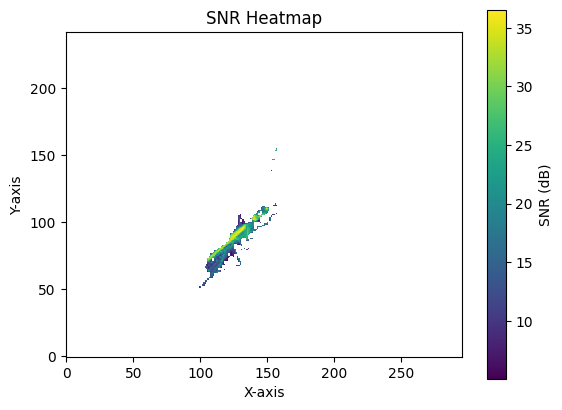

In [11]:
# --- Compute SNR map from RSS tensor and scene noise power ---
def my_snr(rss_map, scene):
    """
    Calculate SNR map in dB from a multi-TX RSS map and scene thermal noise.

    Parameters:
        rss_map : Tensor of shape [num_tx, H, W] with RSS per TX in linear scale
        scene   : Scene object (for thermal noise power)

    Returns:
        snr_db                : SNR map in dB (NaN for values below threshold)
        max_snr               : Maximum SNR value (dB)
        blocks_above_threshold: Number of non-NaN (valid) blocks above threshold
    """
    sum_rss = np.sum(rss_map, axis=0)         # Aggregate RSS from all transmitters
    noise = scene.thermal_noise_power         # Thermal noise (linear scale)

    snr_linear = sum_rss / noise              # SNR in linear scale
    snr_db = 10 * np.log10(snr_linear)        # Convert to dB

    snr_db[snr_db < 5] = np.nan               # Mask out low-SNR regions
    max_snr = np.nanmax(snr_db)               # Max SNR value
    blocks_above_threshold = np.sum(~np.isnan(snr_db))  # Count blocks above threshold

    return snr_db, max_snr, blocks_above_threshold

    
# --- Plot SNR Heatmap ---
def plot_snr_map(cmapp):
    """
    Plot a heatmap of the SNR map in dB.
    """
    plt.imshow(cmapp, cmap='viridis', origin='lower')
    plt.colorbar(label="SNR (dB)")
    plt.title("SNR Heatmap")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()

# --- Run SNR Analysis and Visualize ---
snr, max_snr, blocks = my_snr(cm_2tx_real.rss, scene2)

print("Maximum SNR in the map:", max_snr)
print("Blocks above the threshold:", blocks)

plot_snr_map(snr)

In [12]:
scene2.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …